# Face recognition   
在这个任务中实现对名人的面部识别

## 0. 先决条件   
1. 导入需要用到的库

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler    

import torchvision
from torchvision import datasets,transforms 

## 1. (一)数据准备   
+ 我们已经解压好了，不用再解压数据了


In [2]:
import zipfile
with zipfile.ZipFile("face_data.zip","r") as zip_ref:
    zip_ref.extractall("./")
with zipfile.ZipFile("face_test.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [2]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]   

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])   

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])   

train_dir = 'face_data/train/'
test_dir = 'face_data/val/'   

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)   

test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform)   

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                           shuffle=True, num_workers=4)   

test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=4)

打印两个数据集可以查看基本信息：
```python
print(train_data)
print(test_data)
```  


```python   
Dataset ImageFolder
    Number of datapoints: 121
    Root location: face_data/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )   
```   

```python
Dataset ImageFolder
    Number of datapoints: 30
    Root location: face_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

```

> 注：使用ImageFolder要求数据集的组织形式是：    
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png  

```  

在这里 `root='face_data/train/'`，则各个目录下的文件夹的名字将可被`train_loader.classes`读取为类别参数。
+ 注：如果数据目录下的图片很多，会涉及在创建数据集的时候不要一次性读入所有图片而是应当读取 csv或者文本文件做label等？？？

In [4]:
class_names = train_data.classes

print(class_names)
print(len(class_names))

['ben_afflek', 'brad_pitt', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
6


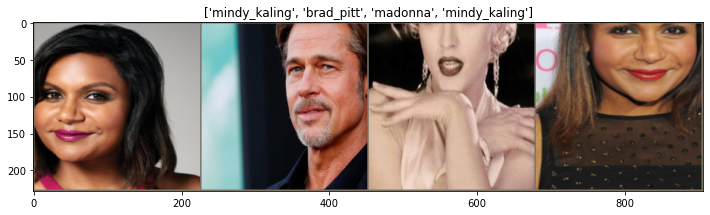

In [5]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(2)
    
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])  # classes=tensor([1207, 1554, 1933,  858])

---
## 2. (二)模型准备   
+ 从 torchvision 导入训练过的 `alexnet` 模型


In [6]:
from torchvision import models

model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\123/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


In [7]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

+ 查看全卷积输出层 4096->1000类

In [8]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

+ **创建自定的分类器，输出类别的数量是自己读取的**  -- len(class_names)=6

In [9]:
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

In [10]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 3. (二)训练过程   尝试新的损失函数
+ GPU - device判断
+ 损失函数和优化器
+ 将train过程写成函数，训练函数的输入为：
 + 网络模型
 + 损失函数
 + 优化器
 + epochs
 

+ 额**重写训练过程**为熟悉的形式
 + 实现保存验证集损失最小的那个模型用作 4.test验证精度

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [26]:
import time
import copy
import os

dataset_sizes = {
    'train': len(train_data),
    'test': len(test_data)
}

In [27]:
def train_model(model, criterion, optimizer, num_epochs=500):
    since = time.time()
    FT_losses = []
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                phase, epoch_loss, epoch_acc*100))
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [28]:
model, FT_losses = train_model(model, criterion, optimizer, num_epochs=500)

Epoch 0/499
----------
train Loss: 7.3054 Acc: 1.2903
test Loss: 12.3090 Acc: 2.7500
Epoch 1/499
----------
train Loss: 5.4760 Acc: 1.7742
test Loss: 8.8800 Acc: 3.7500
Epoch 2/499
----------
train Loss: 4.5861 Acc: 2.3226
test Loss: 8.1034 Acc: 4.7500
Epoch 3/499
----------
train Loss: 4.2823 Acc: 2.4516
test Loss: 8.2113 Acc: 4.2500
Epoch 4/499
----------
train Loss: 3.3471 Acc: 2.5484
test Loss: 5.5711 Acc: 6.7500
Epoch 5/499
----------
train Loss: 3.6510 Acc: 2.5806
test Loss: 9.2428 Acc: 4.2500
Epoch 6/499
----------
train Loss: 3.2940 Acc: 2.6774
test Loss: 6.6952 Acc: 4.7500
Epoch 7/499
----------
train Loss: 4.0899 Acc: 2.5161
test Loss: 6.4076 Acc: 4.5000
Epoch 8/499
----------
train Loss: 3.5966 Acc: 2.5161
test Loss: 4.9951 Acc: 5.5000
Epoch 9/499
----------
train Loss: 3.3370 Acc: 2.5806
test Loss: 8.5372 Acc: 4.5000
Epoch 10/499
----------
train Loss: 2.5969 Acc: 2.9032
test Loss: 5.7022 Acc: 5.2500
Epoch 11/499
----------
train Loss: 3.5894 Acc: 2.6129
test Loss: 7.8990 A

## 4. (三)测试过程-使用测试集测试精度


+ 搞错了吧，应该用 val验证，用test测试；上面是使用了train文件夹下的数据(包括valid数据)
+ 下边又使用valid进行精度测试
+ 在下边是使用test集~~测试~~  应用了？

In [29]:
with torch.no_grad():
    
    correct = 0
    total = 0

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
    base_path = "face_data/val/"

    test_data = datasets.ImageFolder(root=base_path,
                                transform=test_transform)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=4)

    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         print(predicted)
    print('Accuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

Accuracy of the model on the test images: 93.33333333333333%


## 5. (三)应用，
输入一张图片：从谷歌搜索一张名人的照片

+ For running the predictions without knowing the labels for a bunch of images in a folder 用于在不知道文件夹中一堆图像的标签的情况下运行预测
+ 我们实现的是对于一张图像在不知道label的情况下预测输出

输出：Test your model on some face images to say the name of the celebrity most similar to the image

['jerry-seinfeld-kesha.jpg', 'phyynviqok1.jpg', '5d31fa2336e03c040d3e2ee4.jpg', '501720434.jpg', 'c7108defde5c3f593ee0152fe904d1c3--brad-pitt-movies-beautiful-men.jpg', 'mindy-kaling-the-office.jpg', 'rs_600x600-200328163728-600.ben-affleck-ana-de-armas-2.ct.032820.jpg', 'unnamed.jpg', 'elton-john-dog-dies-t.jpg', '5760616191058425008c8f56.jpg', '2019_06_30_75478_1561866556._large.jpg', 'mindy-kaling.jpg', 'wayback4.0.jpeg']


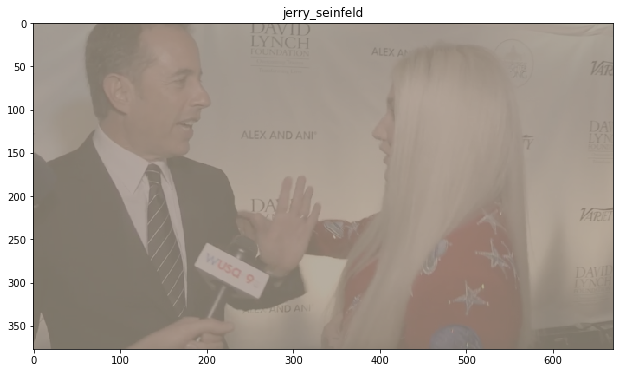

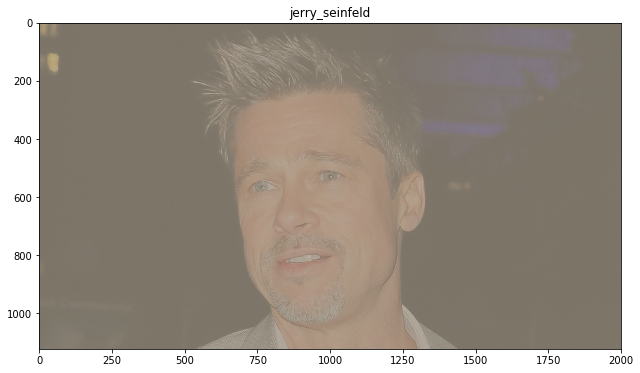

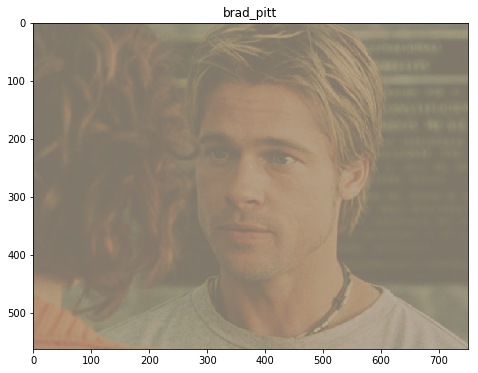

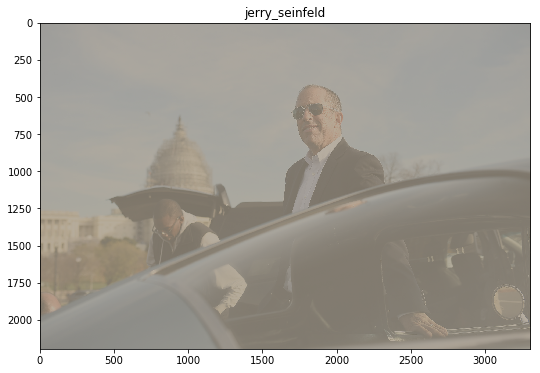

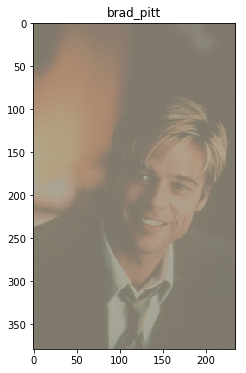

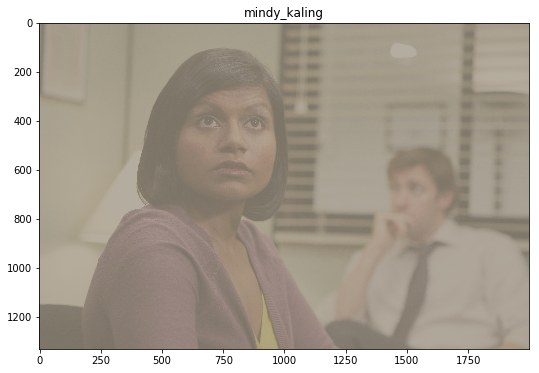

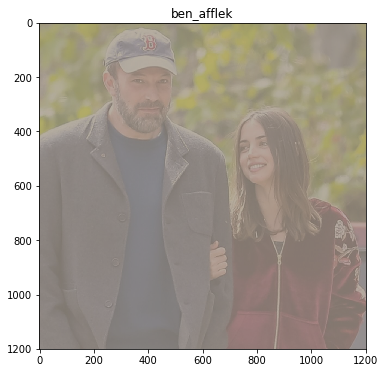

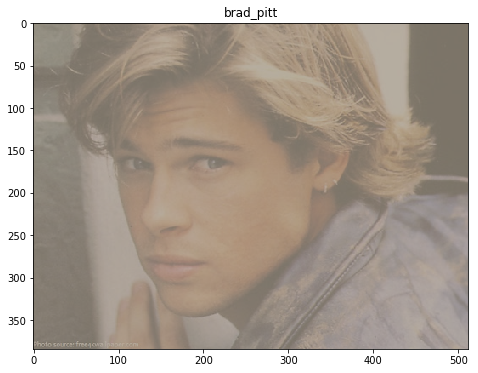

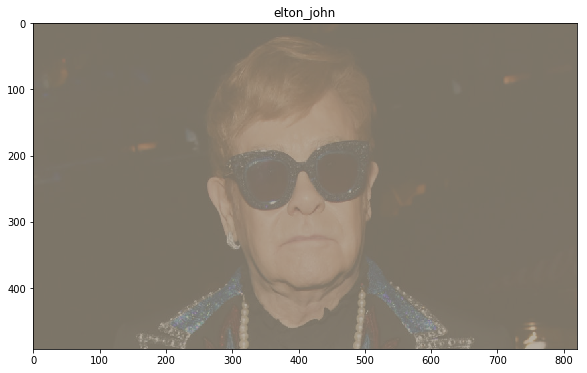

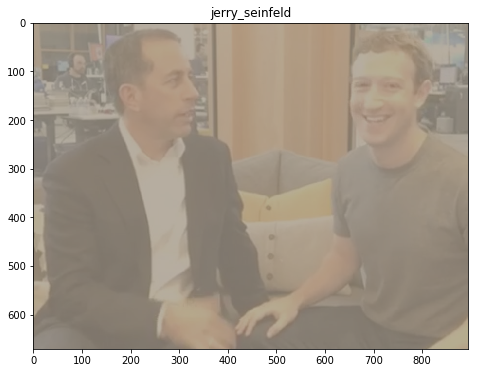

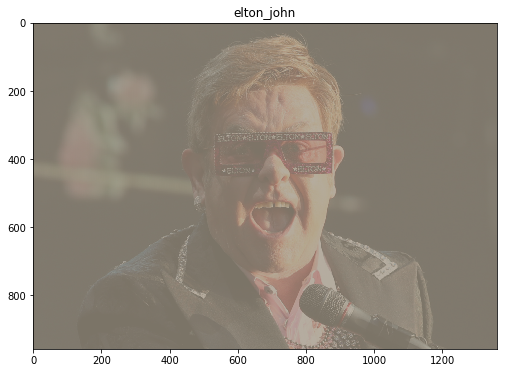

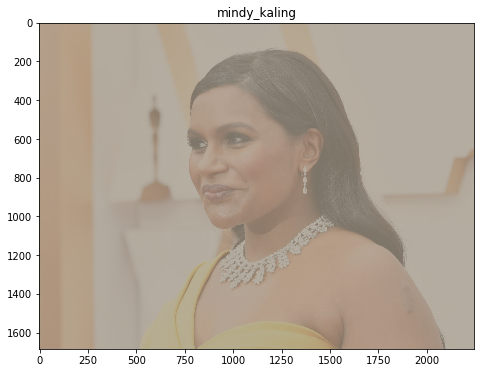

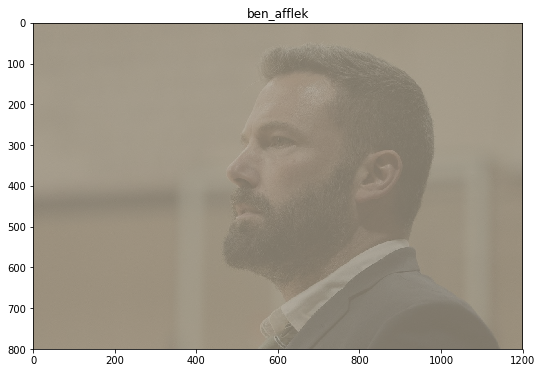

In [30]:
import glob
from PIL import Image
from torch.autograd import Variable
from os import listdir

with torch.no_grad():
    
    base_path = "./face_test/"
    correct = 0
    total = 0
    array = ['ben_afflek', 'brad_pitt' ,'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
    onlyfiles = [f for f in listdir(base_path)]
    print(onlyfiles)
    for files in onlyfiles:
        images=glob.glob(base_path + files)
        for image in images:
            img = Image.open(image)
            trans = transforms.ToPILImage()
            trans1 = transforms.ToTensor()
            transformed_image = test_transform(img).float()
            transformed_image = Variable(transformed_image, requires_grad=True)
            transformed_image = transformed_image.unsqueeze(0)
    #         plt.imshow(transformed_image)
    #         print(transformed_image)
            transformed_image = transformed_image.to(device)
            outputs = model(transformed_image)
            _, predicted = torch.max(outputs.data, 1)
            predicted_index_value = predicted.cpu().numpy()[0]
#             print("Predicted image is : " +array[predicted_index_value])
            imshow(trans1(img),array[predicted_index_value])


In [31]:
# save model
torch.save(model, './model_final')

In [ ]:
import boto3
file_name = './model_final'
s3 = boto3.resource('s3')
bucket='pytorch-models-face' # Replace with your s3 bucket name
s3.meta.client.upload_file(file_name, bucket, 'final_pytorch_model')

### Use the below code to load the model and use again to evaluate ###

In [ ]:
import torch
import torchvision
from torchvision import datasets,transforms 

import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(2)

model = torch.load('./saved_model')
model.eval()